UMAP not found. 'plot_clusters_2D' will fall back to t-SNE if UMAP is selected.
dtaidistance.dtw imported successfully!
fastdtw imported successfully!
All common libraries imported successfully!
Ready for clustering analysis in Jupyter environment

 STARTING EXAMPLE EXECUTION 

--- Running Example 1: Time Series Clustering (Stoppage Reason as groups) ---
This example uses DTW distance for clustering time series sequences.
🚀 Starting Complete Clustering Analysis
Data loaded successfully! Original shape: (569, 10)
Encoded 'Resource' to 'Resource_encoded': {'Resource 1': np.int64(0)}
Encoded 'Line' to 'Line_encoded': {'Line 2': np.int64(0)}
Encoded 'Stoppage Category' to 'Stoppage Category_encoded': {'Planned Stoppages': np.int64(0), 'Production Time': np.int64(1), 'Unplanned Stoppages': np.int64(2)}
Encoded 'Stoppage Sub Category' to 'Stoppage Sub Category_encoded': {'Operational Stoppages': np.int64(0), 'Process Failure': np.int64(1), 'Runtime': np.int64(2)}
Encoded 'Shift' to 'Shift_en

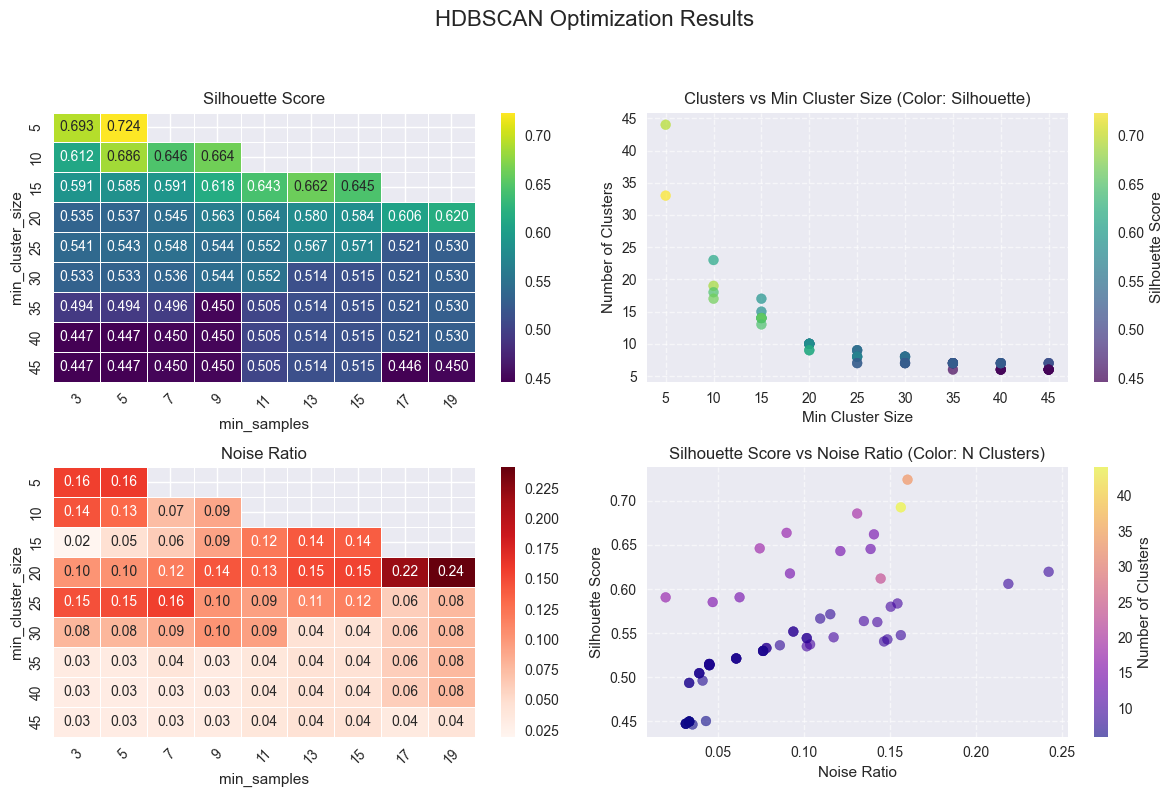


🌳 AHC ANALYSIS
AHCAnalyzer initialized. Data is_time_series_data: False
Optimizing AHC with 'complete' linkage...
Using Euclidean distance for AHC.
Computing linkage matrix with 'complete' method...
Best number of clusters found: 7
Best silhouette score: 0.4122


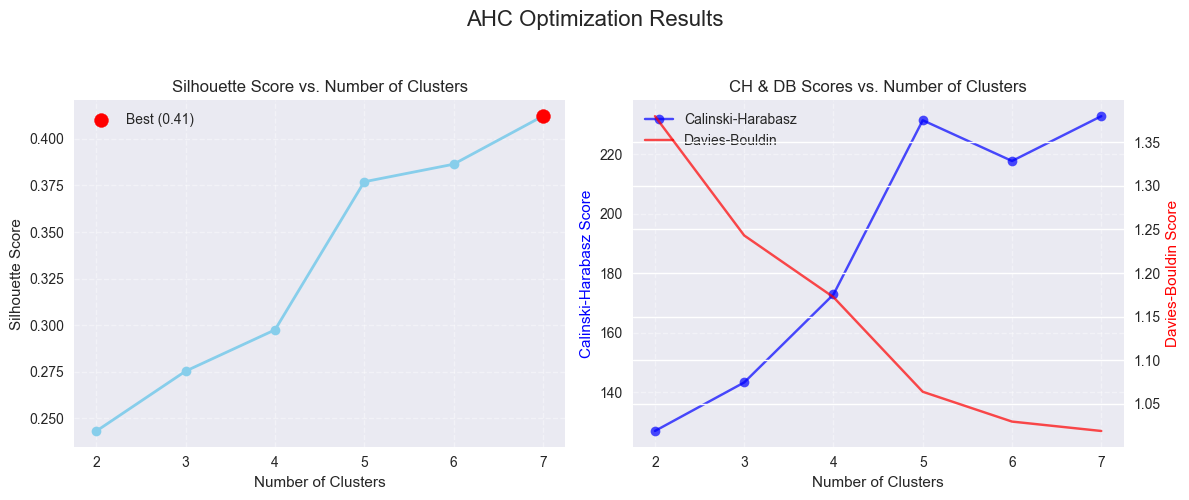

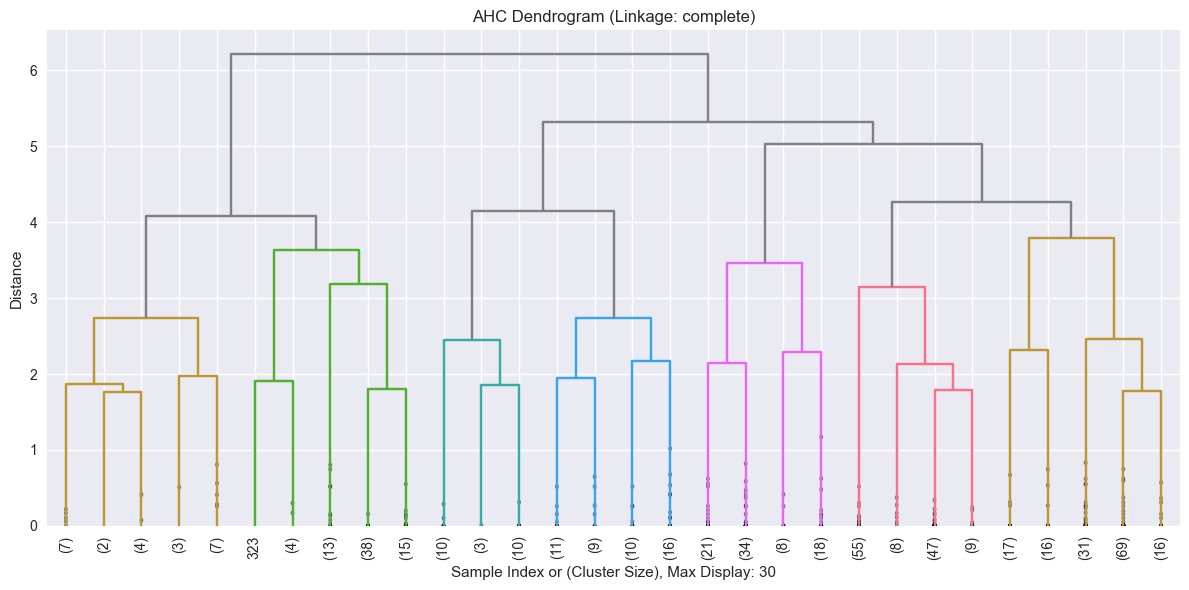


⚖️ CLUSTERING COMPARISON
Applying PCA to reduce data to 2D for visualization...


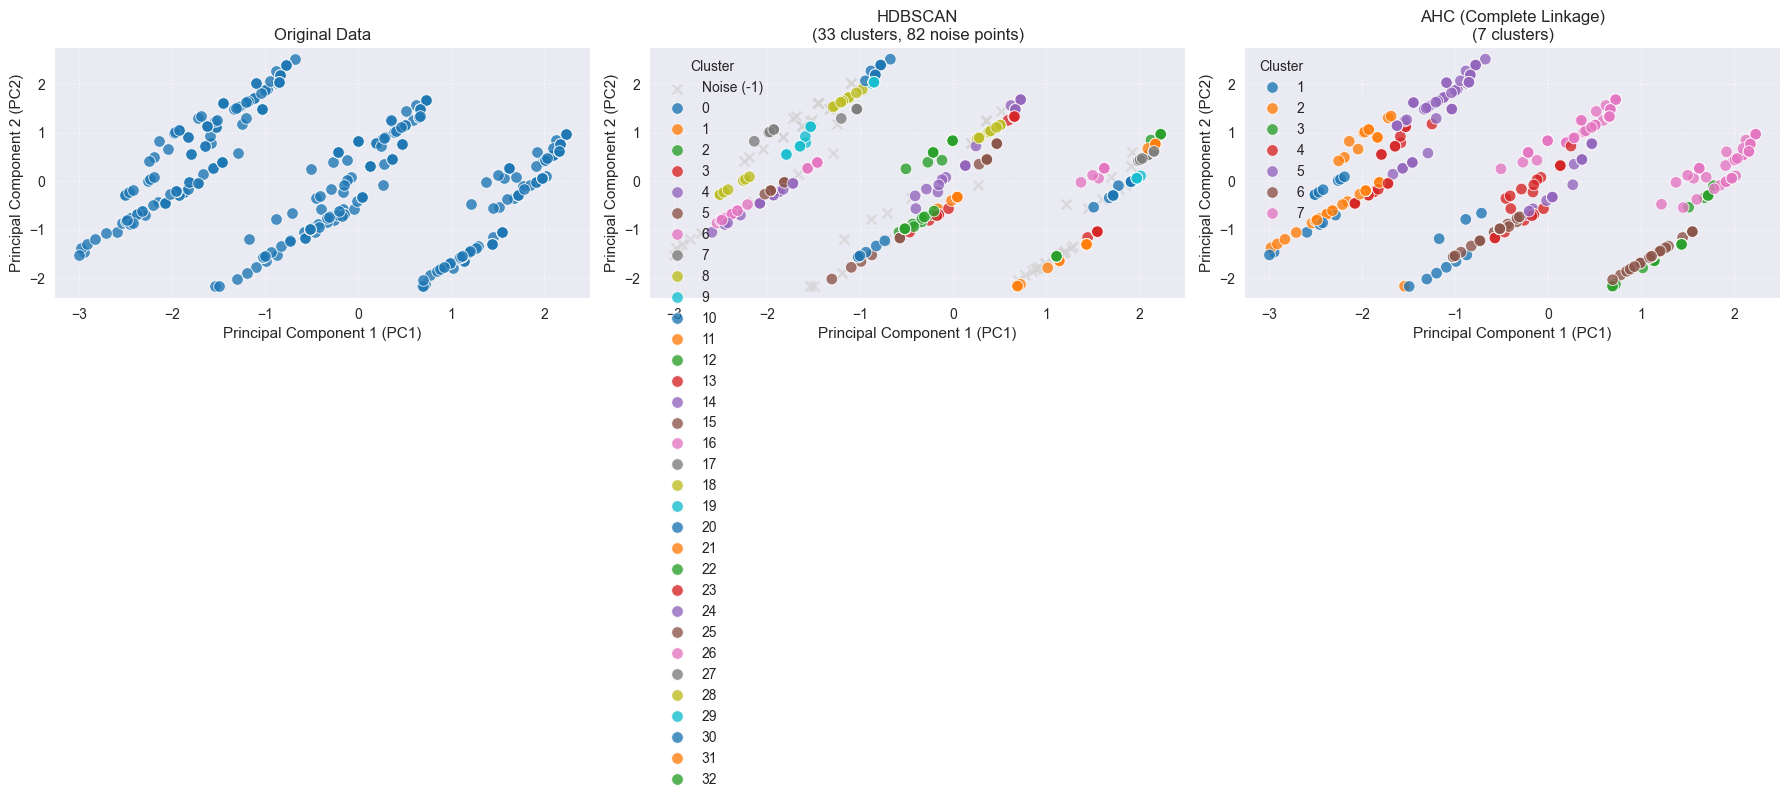


Comparison summary:
              Metric   HDBSCAN       AHC
0         N_Clusters        33         7
1       Noise Points        82         0
2        Noise Ratio      0.16       NaN
3   Silhouette Score    0.7241    0.4122
4  Calinski Harabasz  778.5184  232.7833
5     Davies Bouldin    0.3865    1.0190
6                ARI       NaN       NaN
7                AMI       NaN       NaN

Event-Based Clustering analysis complete. Results available in 'analysis_results_event'.

 ALL EXAMPLES FINISHED 


In [37]:
# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform # pdist for Euclidean, squareform for matrix conversion
import warnings
import joblib # Required for saving models
from sklearn.manifold import TSNE # Required for plot_clusters_2D
from sklearn.decomposition import PCA # Required for plot_clustering_comparison

# Conditional UMAP import
try:
    from umap import UMAP
except ImportError:
    UMAP = None
    print("UMAP not found. 'plot_clusters_2D' will fall back to t-SNE if UMAP is selected.")

warnings.filterwarnings('ignore')

# DTW imports (ensure these are installed: pip install dtaidistance fastdtw)
try:
    from dtaidistance import dtw
    print("dtaidistance.dtw imported successfully!")
except ImportError:
    print("dtaidistance package not found. Please install via 'pip install dtaidistance'")
    dtw = None # Set to None if not available

try:
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    print("fastdtw imported successfully!")
except ImportError:
    print("fastdtw package not found. Please install via 'pip install fastdtw'")
    fastdtw = None # Set to None if not available


# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All common libraries imported successfully!")
print("Ready for clustering analysis in Jupyter environment")


# ============================================================================
# HELPER FUNCTION: CUSTOM DTW DISTANCE CALCULATION
# ============================================================================

def cdist_dtw(sequences):
    """
    Computes the DTW distance matrix for a list of time series sequences.
    Assumes each sequence in the list is a 2D array (time_steps, features).
    Flattens sequences for dtaidistance.dtw.distance for simplicity.
    For more complex multivariate DTW, this function might need adjustment.
    
    Parameters:
    -----------
    sequences : list of np.array
        A list where each element is a time series (can be 1D or 2D).

    Returns:
    --------
    dist_matrix : np.array
        A square matrix of DTW distances between all pairs of sequences.
    """
    if dtw is None:
        raise ImportError("dtaidistance is required for DTW calculations but not imported. Please install it.")

    n_sequences = len(sequences)
    if n_sequences == 0:
        return np.array([[]])
    if n_sequences == 1:
        return np.array([[0.0]])

    dist_matrix = np.zeros((n_sequences, n_sequences))

    print(f"Computing DTW distances for {n_sequences} sequences...")
    for i in range(n_sequences):
        for j in range(i + 1, n_sequences):
            # Flatten sequences if they are 2D for dtaidistance.dtw.distance
            # Ensure sequences are not empty before flattening
            seq1_flat = sequences[i].flatten() if sequences[i].ndim > 1 else sequences[i]
            seq2_flat = sequences[j].flatten() if sequences[j].ndim > 1 else sequences[j]
            
            # Ensure sequences are not empty
            if seq1_flat.size == 0 or seq2_flat.size == 0:
                distance = np.inf # Or some other appropriate value for empty sequences
            else:
                distance = dtw.distance(seq1_flat, seq2_flat)
            
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    print("DTW distance matrix computation complete.")
    return dist_matrix


# ============================================================================
# HELPER FUNCTION: CATEGORICAL ENCODING
# ============================================================================

def encode_categorical_columns(df, exclude_cols=None):
    """
    Encode object-type categorical columns in a DataFrame using LabelEncoder.
    New encoded columns will have '_encoded' suffix.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with categorical columns to encode.
    exclude_cols : list, optional
        Columns to exclude from encoding.

    Returns:
    --------
    df_encoded : pd.DataFrame
        DataFrame with encoded columns added.
    mappings : dict
        Dictionary of encoding mappings for each column.
    """
    df_encoded = df.copy()
    mappings = {}

    if exclude_cols is None:
        exclude_cols = []

    for col in df_encoded.select_dtypes(include='object').columns:
        if col not in exclude_cols:
            le = LabelEncoder()
            encoded_col_name = f"{col}_encoded"
            
            # Create a temporary series without NaNs for fitting
            non_null_values = df_encoded[col].dropna()
            if not non_null_values.empty:
                le.fit(non_null_values)
                # Map values, assign -1 for NaNs (this needs to be handled carefully if -1 is a valid category)
                df_encoded[encoded_col_name] = df_encoded[col].map(lambda x: le.transform([x])[0] if pd.notna(x) else -1)
                mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
                print(f"Encoded '{col}' to '{encoded_col_name}': {mappings[col]}")
            else:
                df_encoded[encoded_col_name] = -1 # All NaNs, assign a unique code
                print(f"Warning: Column '{col}' contains only NaN values. Encoded to -1.")

    # Convert encoded columns to integer type. Fillna with -1 for consistent int type if NaNs existed.
    # Note: If -1 is a valid encoded category, this might cause issues. Consider another NaN placeholder like -999.
    for col_name in [f"{c}_encoded" for c in mappings.keys()]:
        if col_name in df_encoded.columns:
            # Ensure the column is numeric before converting to int to avoid errors if mix types remain
            df_encoded[col_name] = pd.to_numeric(df_encoded[col_name], errors='coerce').fillna(-1).astype(int)
    
    return df_encoded, mappings


# ============================================================================
# MAIN FUNCTION: DATA LOADING AND PREPROCESSING (with Time Series Support)
# ============================================================================

def load_and_preprocess_data(file_path=None, data_df=None, feature_columns=None, 
                           label_column=None, time_column=None, group_column=None,
                           remove_outliers=True, outlier_method='isolation', contamination=0.1, scale=True):
    """
    Load and preprocess tabular data for clustering.
    Handles categorical encoding, feature selection, missing values, outlier removal, and scaling.
    Supports time series data preparation if group_column and time_column are provided.

    Parameters:
    -----------
    file_path : str, optional
        Path to the CSV or Excel file.
    data_df : pd.DataFrame, optional
        Input DataFrame directly. Use instead of file_path.
    feature_columns : list, optional
        List of column names to use as features. If None, all suitable numeric
        (including encoded categoricals) will be selected.
    label_column : str, optional
        Name of the column to treat as the true label (for evaluation).
    time_column : str, optional
        Name of the time column (required for time series sequencing or ordering).
    group_column : str, optional
        Name of the column to group by for time series sequences.
        If provided along with `time_column`, time series clustering is performed
        on sequences grouped by this column.
        If `time_column` is provided but `group_column` is None, data is treated
        as a single time series (each row is a sample).
        If both are None, data is treated as independent samples.
    max_clusters_ahc : int, default 10
        Maximum number of clusters to evaluate for AHC.
    remove_outliers : bool, default True
        Whether to remove outliers.
    outlier_method : str, default 'isolation'
        Method for outlier detection ('isolation' or 'lof').
    contamination : float, default 0.1
        The proportion of outliers in the data set. Used by IsolationForest and LOF.
    scale : bool, default True
        Whether to scale features using StandardScaler.

    Returns:
    --------
    tuple:
        (X, y, final_feature_columns, outlier_mask)
        X: np.array (2D) or list of np.array (sequences), depending on time series flags.
        y: np.array or None
        final_feature_columns: list of str
        outlier_mask: np.array (boolean mask for original DataFrame)
    """

    # Load data
    if file_path:
        try:
            if file_path.endswith('.csv'):
                df = pd.read_csv(file_path)
            elif file_path.endswith(('.xlsx', '.xls')):
                df = pd.read_excel(file_path)
            else: # Default to CSV if extension is unknown or missing
                df = pd.read_csv(file_path) # Fallback to CSV if no extension
        except FileNotFoundError:
            raise FileNotFoundError(f"The file was not found at the specified path: {file_path}")
        except Exception as e:
            raise Exception(f"Error loading file {file_path}: {e}")
    elif data_df is not None:
        df = data_df.copy()
    else:
        raise ValueError("Please provide either 'file_path' or 'data_df' to load data.")
    
    print(f"Data loaded successfully! Original shape: {df.shape}")
    
    # Store original indices to map back after outlier removal
    original_indices = df.index.copy()

    # Convert datetime columns
    datetime_cols = []
    if time_column and time_column in df.columns:
        df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
        datetime_cols.append(time_column)
    if 'Start Datetime' in df.columns: # Assuming 'Start Datetime' is always present in new data
        df['Start Datetime'] = pd.to_datetime(df['Start Datetime'], errors='coerce')
        if 'Start Datetime' not in datetime_cols: datetime_cols.append('Start Datetime')
    if 'End Datetime' in df.columns:
        df['End Datetime'] = pd.to_datetime(df['End Datetime'], errors='coerce')
        if 'End Datetime' not in datetime_cols: datetime_cols.append('End Datetime')

    # Remove rows where essential datetime columns could not be parsed
    for col in datetime_cols:
        if df[col].isnull().any():
            initial_rows = len(df)
            df.dropna(subset=[col], inplace=True)
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows due to invalid '{col}' entries.")
    
    # Encode categorical columns (original columns remain, new encoded ones are added)
    # Exclude datetime columns, label, group, time for encoding
    exclude_for_encoding = [label_column, group_column] + datetime_cols
    df_processed, categorical_mappings = encode_categorical_columns(df, exclude_cols=exclude_for_encoding)

    # Determine the final set of feature columns to use for X
    final_feature_columns = []
    if feature_columns is None:
        # If no specific features are given, select all suitable numeric columns,
        # which will include the newly encoded categorical ones.
        numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
        for col in numeric_cols:
            if col not in exclude_for_encoding: # Ensure we don't accidentally select label/group/time
                final_feature_columns.append(col)
    else:
        # If specific features are given, ensure we use their encoded versions if they were categorical
        for col in feature_columns:
            encoded_col_name = f"{col}_encoded"
            if encoded_col_name in df_processed.columns:
                final_feature_columns.append(encoded_col_name)
            elif col in df_processed.columns and pd.api.types.is_numeric_dtype(df_processed[col]):
                final_feature_columns.append(col)
            elif col in df_processed.columns and pd.api.types.is_object_dtype(df_processed[col]):
                # If a categorical column was explicitly requested but not encoded for some reason, warn
                print(f"Warning: Categorical feature '{col}' was requested but no encoded version found. It might be excluded if not explicitly handled.")
            else:
                print(f"Warning: Feature '{col}' was requested but is not numeric and no encoded version found. Skipping it.")
    
    if not final_feature_columns:
        raise ValueError("No valid feature columns were selected. Check `feature_columns` or data types.")

    print(f"Features selected for analysis: {final_feature_columns}")
    
    # Sort by group and time if specified (important for time series)
    if group_column and time_column:
        if group_column not in df_processed.columns or time_column not in df_processed.columns:
            raise ValueError(f"'{group_column}' or '{time_column}' not found in DataFrame for time series processing.")
        
        # Ensure 'time_column' is considered for sorting in df_processed
        df_processed = df_processed.sort_values(by=[group_column, time_column]).reset_index(drop=False) # Keep original index
        print(f"Data sorted by '{group_column}' and '{time_column}' for time series processing.")
    elif time_column: # If only time_column is given, treat as a single continuous series
        if time_column not in df_processed.columns:
            raise ValueError(f"'{time_column}' not found in DataFrame for time series processing.")
        df_processed = df_processed.sort_values(by=[time_column]).reset_index(drop=False)
        print(f"Data sorted by '{time_column}' for single time series processing.")

    # Extract features and labels (before outlier removal for full context)
    # Ensure all selected features are numeric (fillna before conversion if necessary)
    X_full = df_processed[final_feature_columns].apply(pd.to_numeric, errors='coerce').values
    y_full = df_processed[label_column].values if label_column and label_column in df_processed.columns else None
    
    # Handle missing values after conversion to numeric (if errors='coerce' created NaNs)
    if np.any(pd.isna(X_full)):
        print("Handling missing values (NaNs) by mean imputation...")
        # Impute column-wise means, handle all-NaN columns by 0 or a fixed value
        col_means = np.nanmean(X_full, axis=0)
        col_means[np.isnan(col_means)] = 0 # If a column is all NaNs, impute with 0
        X_full = np.nan_to_num(X_full, nan=col_means) # Impute NaNs with computed means

    # Check if X_full is still valid for outlier detection
    if X_full.shape[0] == 0:
        print("Warning: No data left after preprocessing for outlier detection.")
        return np.array([]), None, final_feature_columns, np.array([]) # Return empty data
    
    # Check if all values are identical (IsolationForest might struggle)
    if X_full.ndim > 1 and np.all(X_full == X_full[0, 0]):
        print("Warning: All feature values are identical. Skipping outlier detection as it may fail.")
        remove_outliers = False # Force skip outlier removal if all values are same


    # Initialize outlier mask to include all points
    outlier_mask = np.ones(len(X_full), dtype=bool)

    # Remove outliers if requested
    if remove_outliers:
        print(f"Attempting to remove outliers using '{outlier_method}' method (contamination={contamination})...")
        if outlier_method == 'isolation':
            try:
                detector = IsolationForest(contamination=contamination, random_state=42)
                preds = detector.fit_predict(X_full)
                outlier_mask = (preds == 1) # 1 for inliers, -1 for outliers
                n_outliers = np.sum(~outlier_mask)
                if n_outliers > 0:
                    print(f"Removed {n_outliers} outliers ({n_outliers/len(X_full)*100:.1f}%)")
                else:
                    print("No outliers detected or removed.")
            except Exception as e:
                print(f"Error during IsolationForest outlier detection: {e}. Skipping outlier removal.")
                outlier_mask = np.ones(len(X_full), dtype=bool) # Revert mask to keep all data
        elif outlier_method == 'lof':
            try:
                n_neighbors_lof = max(2, min(50, X_full.shape[0] - 1)) # LOF requires at least 2 samples, and n_neighbors <= n_samples-1
                if X_full.shape[0] > 1: # Only proceed if enough samples for LOF
                    detector = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors_lof)
                    preds = detector.fit_predict(X_full)
                    outlier_mask = (preds == 1)
                    n_outliers = np.sum(~outlier_mask)
                    if n_outliers > 0:
                        print(f"Removed {n_outliers} outliers ({n_outliers/len(X_full)*100:.1f}%)")
                    else:
                        print("No outliers detected or removed.")
                else:
                    print("Skipping LOF outlier detection: Not enough samples (needs > 1).")
            except Exception as e:
                print(f"Error during LOF outlier detection: {e}. Skipping outlier removal.")
                outlier_mask = np.ones(len(X_full), dtype=bool)
        else:
            raise ValueError("Invalid 'outlier_method'. Choose 'isolation' or 'lof'.")
    
    # Filter X_full and y_full using the outlier_mask
    X_filtered = X_full[outlier_mask]
    y_filtered = y_full[outlier_mask] if y_full is not None else None
    
    # Scale features if requested (only apply to the non-outlier data)
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_filtered)
        print("Features scaled using StandardScaler.")
    else:
        X_scaled = X_filtered
    
    # Prepare data for clustering based on whether it's time series
    if group_column and time_column: # Clustering sequences per group
        sequences = []
        # Need to use the original indices of df_processed that are NOT outliers
        # and then map X_scaled values back to these for grouping.
        df_for_sequencing = df_processed.loc[df_processed.index[outlier_mask]].copy() # Filter df_processed directly and make copy
        
        # Ensure numeric features are used for assigning scaled values
        df_for_sequencing[final_feature_columns] = X_scaled 

        unique_groups = df_for_sequencing[group_column].unique()
        for g in unique_groups:
            # Ensure sequence is not empty before appending
            seq_data = df_for_sequencing[df_for_sequencing[group_column] == g].sort_values(by=time_column)[final_feature_columns].values
            if seq_data.shape[0] > 0: 
                sequences.append(seq_data)
        
        print(f"Prepared {len(sequences)} sequences for DTW/time series analysis (after outlier removal and scaling).")
        return sequences, y_filtered, final_feature_columns, outlier_mask
    elif time_column: # Single time series, where each row is a time point in that series
        print(f"Treating data as a single time series, ordered by '{time_column}'.")
        return X_scaled, y_filtered, final_feature_columns, outlier_mask
    else: # Standard event-based (each row is an independent sample)
        print("Data treated as independent samples (not time series sequences).")
        return X_scaled, y_filtered, final_feature_columns, outlier_mask


class HDBSCANAnalyzer:
    def __init__(self, X, y=None):
        """
        Initialize with feature matrix X and optional true labels y.
        X can be feature vectors (np.array) or a precomputed distance matrix (np.array).
        """
        self.X = X
        self.y = y
        self.results = {}
        self.best_model = None

    def optimize_parameters(self, min_cluster_sizes=None, min_samples_range=None, 
                            metric='euclidean', cluster_selection_method='leaf', verbose=True):
        """
        Grid search over min_cluster_size and min_samples parameters of HDBSCAN
        to maximize silhouette score.
        
        Parameters:
        -----------
        min_cluster_sizes : iterable, optional
            Range of min_cluster_size values to test. Defaults to range(5, min(50, len(X)//10), 5).
        min_samples_range : iterable, optional
            Range of min_samples values to test. Defaults to range(3, min(20, len(X)//20), 2).
        metric : str, default 'euclidean'
            Metric to use for distance calculation. Use 'precomputed' if X is a distance matrix.
        cluster_selection_method : str, default 'leaf'
            The method used to select clusters from the condensed tree.
            'eom' (Excess of Mass) is recommended for 'precomputed' metric.
        verbose : bool, default True
            Whether to print progress messages.

        Returns:
        --------
        tuple : (dict, float)
            A tuple containing the best parameters found and the corresponding best silhouette score.
        """
        n_samples = len(self.X)
        if n_samples < 2:
            print("Warning: Not enough samples for HDBSCAN clustering. Skipping optimization.")
            self.results = {'best_params': {}, 'best_score': -1, 'all_results': []}
            return {}, -1

        if min_cluster_sizes is None:
            min_cluster_sizes = range(5, max(6, min(50, n_samples // 10)), 5) # Ensure range is valid
        if min_samples_range is None:
            min_samples_range = range(3, max(4, min(20, n_samples // 20)), 2) # Ensure range is valid

        if verbose:
            print("Optimizing HDBSCAN parameters...")
            print(f"Testing min_cluster_sizes: {list(min_cluster_sizes)}")
            print(f"Testing min_samples: {list(min_samples_range)}")
            print(f"Using metric: '{metric}' and cluster_selection_method: '{cluster_selection_method}'")


        best_score = -1
        best_params = {}
        all_results = []

        min_cluster_sizes_list = list(min_cluster_sizes)
        min_samples_range_list = list(min_samples_range)

        if not min_cluster_sizes_list or not min_samples_range_list:
            print("Warning: Empty parameter ranges provided for HDBSCAN optimization. Skipping optimization.")
            return {}, -1

        for min_cluster_size in min_cluster_sizes_list:
            for min_samples in min_samples_range_list:
                try:
                    # HDBSCAN requires min_samples <= min_cluster_size
                    if min_samples > min_cluster_size:
                        continue

                    clusterer = hdbscan.HDBSCAN(
                        min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        metric=metric,
                        cluster_selection_method=cluster_selection_method,
                        gen_min_span_tree=True, # Recommended for stability and visualization
                        allow_single_cluster=True # Allow single cluster if data dictates
                    )
                    cluster_labels = clusterer.fit_predict(self.X)
                    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

                    # Skip cases with less than 2 actual clusters (excluding noise)
                    if n_clusters < 2:
                        continue

                    # Silhouette score only on non-noise points
                    mask = cluster_labels != -1
                    if np.sum(mask) < 2: # Need at least 2 points (and 2 clusters) for silhouette
                        continue

                    sil_score = silhouette_score(self.X[mask], cluster_labels[mask], metric=metric if metric != 'precomputed' else 'precomputed')

                    result = {
                        'min_cluster_size': min_cluster_size,
                        'min_samples': min_samples,
                        'n_clusters': n_clusters,
                        'silhouette_score': sil_score,
                        'n_noise': np.sum(cluster_labels == -1),
                        'noise_ratio': np.sum(cluster_labels == -1) / n_samples,
                        'labels': cluster_labels,
                        'model': clusterer
                    }

                    all_results.append(result)

                    if sil_score > best_score:
                        best_score = sil_score
                        best_params = {
                            'min_cluster_size': min_cluster_size,
                            'min_samples': min_samples
                        }
                        self.best_model = clusterer # Store the best model object

                except Exception as e:
                    if verbose:
                        print(f"Skipping min_cluster_size={min_cluster_size}, min_samples={min_samples} due to error: {e}")
                    continue

        self.results = {
            'best_params': best_params,
            'best_score': best_score,
            'all_results': all_results
        }

        if verbose:
            if best_params:
                print(f"Best parameters found: {best_params}")
                print(f"Best silhouette score: {best_score:.4f}")
            else:
                print("No suitable HDBSCAN parameters found within the given ranges.")

        return best_params, best_score

    def get_best_clustering(self):
        """
        Return cluster metrics and labels for the best model found during optimization.
        """
        if not self.best_model:
            # Handle case where no best model was found
            return {
                'labels': np.full(len(self.X), -2), # -2 indicates clustering was skipped/failed
                'n_clusters': 0,
                'n_noise': len(self.X),
                'noise_ratio': 1.0,
                'silhouette_score': np.nan,
                'calinski_harabasz_score': np.nan,
                'davies_bouldin_score': np.nan,
                'ari': np.nan,
                'ami': np.nan
            }

        labels = self.best_model.labels_

        mask = labels != -1
        metrics = {
            'labels': labels,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
            'n_noise': np.sum(labels == -1),
            'noise_ratio': np.sum(labels == -1) / len(labels) if len(labels) > 0 else 0,
        }

        # Determine the metric to use for silhouette_score from the best model's parameters
        # If the best_model was fitted with 'precomputed' metric, use that.
        best_metric = self.best_model.metric if hasattr(self.best_model, 'metric') else 'euclidean'
        
        if np.sum(mask) >= 2 and metrics['n_clusters'] >= 2: # Need at least 2 non-noise points and 2 clusters for these metrics
            metrics['silhouette_score'] = silhouette_score(self.X[mask], labels[mask], metric=best_metric if best_metric != 'precomputed' else 'precomputed')
            metrics['calinski_harabasz_score'] = calinski_harabasz_score(self.X[mask], labels[mask])
            metrics['davies_bouldin_score'] = davies_bouldin_score(self.X[mask], labels[mask])
        else:
            print("Warning: Not enough non-noise points or clusters for silhouette, Calinski-Harabasz, Davies-Bouldin scores.")
            metrics['silhouette_score'] = np.nan
            metrics['calinski_harabasz_score'] = np.nan
            metrics['davies_bouldin_score'] = np.nan

        if self.y is not None:
            # For ARI/AMI, comparing against all data points, including noise if true labels exist for them
            metrics['ari'] = adjusted_rand_score(self.y, labels)
            metrics['ami'] = adjusted_mutual_info_score(self.y, labels)

        return metrics

    def plot_optimization_results(self, figsize=(12, 8)):
        """
        Plot heatmaps and scatter plots summarizing the optimization results.
        """
        if not self.results or not self.results.get('all_results'):
            print("No optimization results to plot. Run optimize_parameters() first.")
            return

        results_df = pd.DataFrame(self.results['all_results'])
        if results_df.empty or results_df['silhouette_score'].isnull().all():
            print("Optimization results DataFrame is empty or contains no valid silhouette scores. Cannot plot.")
            return

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('HDBSCAN Optimization Results', fontsize=16, y=1.02)


        # Silhouette score heatmap
        pivot_sil = results_df.pivot_table(
            values='silhouette_score', 
            index='min_cluster_size', 
            columns='min_samples', 
            aggfunc='mean'
        )
        sns.heatmap(pivot_sil, annot=True, fmt='.3f', ax=axes[0,0], cmap='viridis', linewidths=.5)
        axes[0,0].set_title('Silhouette Score')
        axes[0,0].tick_params(axis='x', rotation=45)


        # Number of clusters vs min_cluster_size (scatter with color by silhouette)
        scatter_01 = axes[0,1].scatter(
            results_df['min_cluster_size'], 
            results_df['n_clusters'],
            c=results_df['silhouette_score'], 
            cmap='viridis', 
            alpha=0.7,
            s=50
        )
        axes[0,1].set_xlabel('Min Cluster Size')
        axes[0,1].set_ylabel('Number of Clusters')
        axes[0,1].set_title('Clusters vs Min Cluster Size (Color: Silhouette)')
        plt.colorbar(scatter_01, ax=axes[0,1], label='Silhouette Score')
        axes[0,1].grid(True, linestyle='--', alpha=0.6)


        # Noise ratio heatmap
        pivot_noise = results_df.pivot_table(
            values='noise_ratio', 
            index='min_cluster_size', 
            columns='min_samples', 
            aggfunc='mean'
        )
        sns.heatmap(pivot_noise, annot=True, fmt='.2f', ax=axes[1,0], cmap='Reds', linewidths=.5)
        axes[1,0].set_title('Noise Ratio')
        axes[1,0].tick_params(axis='x', rotation=45)


        # Silhouette score vs Noise ratio (scatter)
        scatter_11 = axes[1,1].scatter(
            results_df['noise_ratio'], 
            results_df['silhouette_score'], 
            alpha=0.6,
            s=50,
            c=results_df['n_clusters'], # Color by number of clusters
            cmap='plasma'
        )
        axes[1,1].set_xlabel('Noise Ratio')
        axes[1,1].set_ylabel('Silhouette Score')
        axes[1,1].set_title('Silhouette Score vs Noise Ratio (Color: N Clusters)')
        plt.colorbar(scatter_11, ax=axes[1,1], label='Number of Clusters')
        axes[1,1].grid(True, linestyle='--', alpha=0.6)


        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to make space for suptitle
        plt.show()

    def save_best_model(self, path="best_hdbscan_model.pkl"):
        """
        Save the best HDBSCAN model to disk using joblib.
        """
        if self.best_model:
            joblib.dump(self.best_model, path)
            print(f"HDBSCAN model saved to {path}")
        else:
            raise ValueError("No best HDBSCAN model to save. Run optimize_parameters() first.")

    def plot_clusters_2D(self, method='tsne', figsize=(10, 8)):
        """
        Visualize clusters in 2D using t-SNE or UMAP.
        
        Parameters:
        -----------
        method : str, default 'tsne'
            Dimensionality reduction method ('tsne' or 'umap').
        figsize : tuple, default (10, 8)
            Figure size for the plot.
        """
        if not self.best_model or self.best_model.labels_ is None:
            print("No HDBSCAN labels available. Ensure model is fitted.")
            return

        labels = self.best_model.labels_
        
        # If self.X is a distance matrix, we cannot directly apply TSNE/UMAP.
        # We need the original feature data for this plot.
        if self.best_model.metric == 'precomputed':
            print("Cannot directly plot precomputed distance matrix with t-SNE/UMAP. "
                  "This plot requires original feature data (X_original) for visualization.")
            return

        reducer = None
        n_samples = len(self.X)
        if n_samples <= 1:
            print("Not enough samples to perform dimensionality reduction for plotting.")
            return

        # Perplexity must be less than n_samples
        tsne_perplexity = min(30, n_samples - 1)
        if tsne_perplexity < 1: tsne_perplexity = 1 # min value for perplexity, if n_samples is 1

        if method == 'tsne':
            reducer = TSNE(n_components=2, random_state=42, perplexity=tsne_perplexity)
        elif method == 'umap':
            if UMAP:
                reducer = UMAP(n_components=2, random_state=42)
            else:
                print("UMAP not installed. Falling back to t-SNE.")
                reducer = TSNE(n_components=2, random_state=42, perplexity=tsne_perplexity)
                method = 'tsne'
        else:
            raise ValueError("Invalid method. Use 'tsne' or 'umap'.")

        if reducer is None:
             print("Could not initialize a dimensionality reducer. Plotting skipped.")
             return

        print(f"Reducing data to 2D using {method.upper()} for visualization...")
        embedding = reducer.fit_transform(self.X)

        plt.figure(figsize=figsize)
        unique_labels = np.unique(labels)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        # Handle case where all points are noise or very few actual clusters
        if num_clusters == 0 and np.sum(labels == -1) > 0: # All noise
            print("All points are noise. Plotting noise points only.")
            sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],
                            color='lightgray', marker='x', s=50, alpha=0.7, label='Noise (-1)')
        elif num_clusters >= 1: # At least one actual cluster, potentially with noise
            # Plot noise points first in grey
            noise_mask = (labels == -1)
            if np.sum(noise_mask) > 0:
                sns.scatterplot(x=embedding[noise_mask, 0], y=embedding[noise_mask, 1],
                                color='lightgray', marker='x', s=50, alpha=0.7, label='Noise (-1)', ax=plt.gca())
                
            cluster_mask = (labels != -1)
            if np.sum(cluster_mask) > 0:
                num_actual_clusters = len(np.unique(labels[cluster_mask]))
                if num_actual_clusters > 1: # Use hue if there's more than one actual cluster
                    sns.scatterplot(x=embedding[cluster_mask, 0], y=embedding[cluster_mask, 1],
                                    hue=labels[cluster_mask], palette='tab10', s=70, alpha=0.8,
                                    legend='full' if num_clusters <= 10 else None, ax=plt.gca())
                else: # Only one valid cluster, assign a single color
                    sns.scatterplot(x=embedding[cluster_mask, 0], y=embedding[cluster_mask, 1],
                                    color=sns.color_palette('tab10')[0], s=70, alpha=0.8, ax=plt.gca())
        
        plt.title(f"{method.upper()} Visualization of HDBSCAN Clusters ({num_clusters} clusters, {np.sum(labels == -1)} noise points)")
        plt.xlabel(f"{method.upper()} Component 1")
        plt.ylabel(f"{method.upper()} Component 2")
        if plt.gca().get_legend():
            plt.gca().get_legend().set_title("Cluster")
        plt.tight_layout()
        plt.show()


class AHCAnalyzer:
    def __init__(self, X, y=None):
        """
        Initialize the AHC analyzer.
        
        Parameters:
        - X: Feature data (numpy array or pandas DataFrame) shape = (n_samples, n_features)
             or list of sequences (for DTW).
        - y: Optional ground truth labels for supervised evaluation.
        """
        self.X = X
        self.y = y
        self.results = {}
        self.linkage_matrix = None
        self.best_labels = None
        self.best_n_clusters = None
        
        # Determine if X is already a list of sequences (for DTW) or a flat 2D array (for Euclidean/other)
        self.is_time_series_data = isinstance(X, list) and all(isinstance(s, np.ndarray) for s in X)
        print(f"AHCAnalyzer initialized. Data is_time_series_data: {self.is_time_series_data}")


    def optimize_clusters(self, max_clusters=10, linkage_method='complete'):
        """
        Optimize the number of clusters using silhouette score.
        Uses DTW distance if data is time series, else Euclidean.
        
        Parameters:
        - max_clusters: Maximum number of clusters to evaluate.
        - linkage_method: Linkage strategy ('complete', 'average', 'single', 'ward').
                          'ward' only works with Euclidean distance.
        
        Returns:
        - best_n_clusters: Number of clusters with the best silhouette score.
        - best_score: Corresponding silhouette score.
        """
        if len(self.X) < 2:
            print("Warning: Not enough samples for clustering. Skipping optimization.")
            self.results = {'best_n_clusters': None, 'best_score': -1, 'all_results': []}
            return None, -1
            
        cluster_range = range(2, min(max_clusters + 1, len(self.X))) # Max clusters cannot exceed num_samples
        if len(cluster_range) < 1:
            print("Warning: Cluster range is too small. Adjust max_clusters or input data size.")
            self.results = {'best_n_clusters': None, 'best_score': -1, 'all_results': []}
            return None, -1


        print(f"Optimizing AHC with '{linkage_method}' linkage...")

        distance_matrix = None
        metric_for_silhouette = 'euclidean' # Default for silhouette_score if not precomputed

        if self.is_time_series_data:
            print("Computing DTW distance matrix...")
            distance_matrix = cdist_dtw(self.X)
            condensed_dist = squareform(distance_matrix)
            # Ensure linkage_method is compatible with precomputed distance ('ward' is not)
            if linkage_method == 'ward':
                print("Warning: 'ward' linkage requires Euclidean distances. Changing to 'complete' for precomputed DTW.")
                linkage_method = 'complete'
            metric_for_silhouette = 'precomputed' # For silhouette_score
        else:
            print("Using Euclidean distance for AHC.")
            condensed_dist = pdist(self.X, metric='euclidean')
            distance_matrix = squareform(condensed_dist) # Create square matrix for silhouette

        # Compute linkage matrix once for efficiency
        print(f"Computing linkage matrix with '{linkage_method}' method...")
        self.linkage_matrix = linkage(condensed_dist, method=linkage_method)


        best_score = -1
        best_n_clusters = None
        all_results = []

        for n_clusters in cluster_range:
            try:
                labels = fcluster(self.linkage_matrix, n_clusters, criterion='maxclust')

                if len(np.unique(labels)) < 2: # Skip if less than 2 actual clusters formed
                    continue

                result = self._calculate_metrics(labels, distance_matrix=distance_matrix,
                                                metric_for_silhouette=metric_for_silhouette)
                result.update({
                    'n_clusters': n_clusters,
                    'labels': labels,
                })

                all_results.append(result)

                if result['silhouette_score'] > best_score:
                    best_score = result['silhouette_score']
                    best_n_clusters = n_clusters
                    self.best_labels = labels
                    self.best_n_clusters = best_n_clusters # Store best_n_clusters for dendrogram

            except Exception as e:
                print(f"Error for n_clusters={n_clusters}: {e}")
                continue

        self.results = {
            'best_n_clusters': best_n_clusters,
            'best_score': best_score,
            'linkage_method': linkage_method,
            'all_results': all_results,
            'distance_matrix': distance_matrix # Store distance matrix for re-calculation if needed
        }

        print(f"Best number of clusters found: {best_n_clusters}")
        print(f"Best silhouette score: {best_score:.4f}")
        return best_n_clusters, best_score

    def _calculate_metrics(self, labels, distance_matrix=None, metric_for_silhouette='euclidean'):
        """
        Calculate clustering evaluation metrics.
        """
        metrics = {
            'n_noise': 0  # Not applicable for AHC in the same way as HDBSCAN
        }
        
        # For Calinski-Harabasz and Davies-Bouldin, input needs to be 2D array
        # Flatten sequences if time series data, to provide a 2D array for these metrics
        X_for_metrics = np.array([s.flatten() for s in self.X]) if self.is_time_series_data else self.X

        # Ensure enough samples and clusters for metrics
        if len(np.unique(labels)) >= 2 and len(labels) >= 2:
            if distance_matrix is not None and metric_for_silhouette == 'precomputed':
                 metrics['silhouette_score'] = silhouette_score(distance_matrix, labels, metric='precomputed')
            else: # Fallback to Euclidean if precomputed not available or specified
                 metrics['silhouette_score'] = silhouette_score(X_for_metrics, labels, metric=metric_for_silhouette)
            
            metrics['calinski_harabasz_score'] = calinski_harabasz_score(X_for_metrics, labels)
            metrics['davies_bouldin_score'] = davies_bouldin_score(X_for_metrics, labels)
        else:
            metrics['silhouette_score'] = np.nan
            metrics['calinski_harabasz_score'] = np.nan
            metrics['davies_bouldin_score'] = np.nan
            print("Warning: Not enough clusters or samples for some evaluation metrics.")

        if self.y is not None:
            metrics.update({
                'ari': adjusted_rand_score(self.y, labels),
                'ami': adjusted_mutual_info_score(self.y, labels)
            })

        return metrics

    def get_best_clustering(self):
        """
        Return evaluation metrics and labels for the best clustering found.
        """
        if self.best_labels is None:
            # Handle case where no best clustering was found
            return {
                'labels': np.full(len(self.X), -2), # -2 indicates clustering was skipped/failed
                'n_clusters': 0,
                'n_noise': 0,
                'silhouette_score': np.nan,
                'calinski_harabasz_score': np.nan,
                'davies_bouldin_score': np.nan,
                'ari': np.nan,
                'ami': np.nan
            }

        # Recalculate metrics using the stored best labels and distance matrix if available
        best_run_results = next((res for res in self.results['all_results'] if np.array_equal(res['labels'], self.best_labels)), None)
        
        if best_run_results:
            metrics = {k: v for k, v in best_run_results.items() if k not in ['labels']} # Exclude the full labels array from generic print
            metrics['labels'] = self.best_labels # Always include labels
            return metrics
        else:
            print("Could not retrieve exact best clustering metrics from stored results. Recalculating...")
            # Fallback to recalculate if the exact result dict wasn't found
            distance_matrix = self.results.get('distance_matrix')
            if distance_matrix is not None:
                metric_for_silhouette = 'precomputed'
            else:
                metric_for_silhouette = 'euclidean'
            
            metrics = self._calculate_metrics(self.best_labels, distance_matrix=distance_matrix,
                                              metric_for_silhouette=metric_for_silhouette)
            metrics.update({
                'labels': self.best_labels,
                'n_clusters': len(set(self.best_labels))
            })
            return metrics


    def plot_optimization_results(self, figsize=(12, 5)):
        """
        Visualize optimization metrics across tested cluster counts.
        """
        if not self.results or not self.results.get('all_results'):
            print("No optimization results to plot. Run optimize_clusters() first.")
            return

        results_df = pd.DataFrame(self.results['all_results'])
        if results_df.empty or results_df['silhouette_score'].isnull().all():
            print("Optimization results DataFrame is empty or contains no valid silhouette scores. Cannot plot.")
            return

        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle('AHC Optimization Results', fontsize=16, y=1.02)


        # Silhouette Score Plot
        axes[0].plot(results_df['n_clusters'], results_df['silhouette_score'], 'o-', linewidth=2, color='skyblue')
        if not results_df['silhouette_score'].isnull().all():
            best_idx = results_df['silhouette_score'].idxmax()
            axes[0].scatter(results_df['n_clusters'].iloc[best_idx],
                            results_df['silhouette_score'].max(),
                            color='red', s=100, zorder=5, label=f'Best ({results_df["silhouette_score"].max():.2f})')
        axes[0].set_title('Silhouette Score vs. Number of Clusters')
        axes[0].set_xlabel('Number of Clusters')
        axes[0].set_ylabel('Silhouette Score')
        axes[0].legend()
        axes[0].grid(alpha=0.4, linestyle='--')


        # Calinski-Harabasz and Davies-Bouldin Comparison
        ax1 = axes[1]
        ax2 = ax1.twinx()

        ch_line = ax1.plot(results_df['n_clusters'], results_df['calinski_harabasz_score'],
                      'o-', label='Calinski-Harabasz', color='blue', alpha=0.7)
        db_line = ax2.plot(results_df['n_clusters'], results_df['davies_bouldin_score'],
                      'x-', label='Davies-Bouldin', color='red', alpha=0.7)

        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Calinski-Harabasz Score', color='blue')
        ax2.set_ylabel('Davies-Bouldin Score', color='red')
        ax1.set_title('CH & DB Scores vs. Number of Clusters')
        ax1.grid(alpha=0.4, linestyle='--')

        # Combine Legends
        lines = ch_line + db_line
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left')

        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()

    def plot_dendrogram(self, figsize=(12, 6), max_display_leaves=30, color_threshold=None):
        """
        Plot the dendrogram of the hierarchical clustering.
        
        Parameters:
        - figsize: Size of the dendrogram plot.
        - max_display_leaves: Maximum number of leaves to display at the bottom (clusters/samples).
                              Use 0 for full dendrogram.
        - color_threshold: Distance threshold beyond which clusters will be colored differently.
                           If None, auto-calculated for the best_n_clusters.
        """
        if self.linkage_matrix is None or len(self.linkage_matrix) == 0:
            print("Linkage matrix is not available or empty. Run optimize_clusters() first.")
            return

        plt.figure(figsize=figsize)
        
        effective_color_threshold = color_threshold # Use user-provided if any

        if effective_color_threshold is None and self.best_n_clusters is not None:
            n_merges = len(self.linkage_matrix)
            # Calculate threshold only if enough merges exist to form best_n_clusters
            if self.best_n_clusters > 1 and n_merges >= (self.best_n_clusters - 1):
                effective_color_threshold = self.linkage_matrix[n_merges - self.best_n_clusters + 1, 2]
            else:
                effective_color_threshold = 0 # No meaningful threshold for 0 or 1 cluster

        above_threshold_color_arg = None
        # Only set above_threshold_color if a positive, non-zero threshold is applied
        if effective_color_threshold is not None and effective_color_threshold > 0:
            above_threshold_color_arg = 'gray'

        dendrogram(
            self.linkage_matrix,
            truncate_mode='lastp' if max_display_leaves > 0 else None,
            p=max_display_leaves if max_display_leaves > 0 else None,
            leaf_rotation=90.,
            leaf_font_size=10.,
            show_contracted=True,
            color_threshold=effective_color_threshold, # Use the determined threshold
            above_threshold_color=above_threshold_color_arg # Use the determined color arg (can be None or 'gray')
        )

        plt.title(f'AHC Dendrogram (Linkage: {self.results.get("linkage_method", "N/A")})')
        plt.xlabel(f'Sample Index or (Cluster Size), Max Display: {max_display_leaves}')
        plt.ylabel('Distance')
        plt.tight_layout()
        plt.show()


# ============================================================================
# HELPER FUNCTION: CLUSTERING VISUALIZATION COMPARISON
# ============================================================================

def plot_clustering_comparison(X_original_for_plotting, hdbscan_labels, ahc_labels, feature_names=None, figsize=(18, 6), use_dim_reduction=True):
    """
    Plot comparison of clustering results for time series or vector data.
    Automatically handles dimensionality reduction for high-dimensional data.
    
    Parameters:
    - X_original_for_plotting: Original (or flattened) data array, shape (n_samples, n_features).
                               This should be the data used for dimensionality reduction/plotting.
    - hdbscan_labels: cluster labels from HDBSCAN (with -1 noise).
    - ahc_labels: cluster labels from AHC.
    - feature_names: list of feature names (optional).
    - figsize: figure size tuple.
    - use_dim_reduction: if True, reduce dimensionality to 2D for visualization (recommended for high-dim).
    """
    if not isinstance(X_original_for_plotting, np.ndarray) or X_original_for_plotting.ndim < 1 or X_original_for_plotting.shape[0] == 0:
        print("Invalid or empty input for X_original_for_plotting. Cannot plot.")
        return

    n_samples = X_original_for_plotting.shape[0]
    if n_samples == 0:
        print("No samples to plot.")
        return

    # If high-dim, do dimensionality reduction
    X_embedded = X_original_for_plotting
    xlabel = 'Feature 1'
    ylabel = 'Feature 2'

    if (X_original_for_plotting.ndim == 2 and X_original_for_plotting.shape[1] > 2) and use_dim_reduction:
        print("Applying PCA to reduce data to 2D for visualization...")
        n_components = min(2, X_original_for_plotting.shape[0], X_original_for_plotting.shape[1])
        if n_components < 2:
            print(f"Warning: Cannot reduce to 2D for plotting, n_components={n_components}. Skipping dim reduction.")
            # If still more than 1 feature, fall back to 1D plot or skip
            if X_original_for_plotting.shape[1] == 1:
                X_embedded = X_original_for_plotting
                xlabel = feature_names[0] if feature_names and len(feature_names) > 0 else 'Feature Value'
                ylabel = 'Sample Index'
            else: # Cannot reduce to 2D and still have >1 feature, but not time series
                print("Cannot plot high-dimensional data directly without 2D reduction. Skipping comparison plot.")
                return
        else:
            pca = PCA(n_components=n_components, random_state=42)
            X_embedded = pca.fit_transform(X_original_for_plotting)
            xlabel = 'Principal Component 1 (PC1)'
            ylabel = 'Principal Component 2 (PC2)'
    elif X_original_for_plotting.ndim == 1: # Convert 1D array to 2D for consistent plotting
        X_embedded = X_original_for_plotting.reshape(-1, 1)
        xlabel = feature_names[0] if feature_names and len(feature_names) > 0 else 'Feature Value'
        ylabel = 'Sample Index'
    elif X_original_for_plotting.ndim == 2 and X_original_for_plotting.shape[1] == 1:
        X_embedded = X_original_for_plotting
        xlabel = feature_names[0] if feature_names and len(feature_names) > 0 else 'Feature Value'
        ylabel = 'Sample Index'


    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Helper for scatter plotting (handles 1D vs 2D embedding)
    def _plot_scatter(ax, embedded_data, labels, title, is_hdbscan=False):
        if embedded_data.shape[1] == 2:
            x_data, y_data = embedded_data[:, 0], embedded_data[:, 1]
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        else: # Assumed 1D data, plot against index
            x_data, y_data = embedded_data[:, 0], np.arange(len(embedded_data))
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)

        unique_labels_to_plot = np.unique(labels)
        # Handle cases where clustering was skipped or resulted in no valid clusters
        if len(unique_labels_to_plot) == 1 and (unique_labels_to_plot[0] == -2 or unique_labels_to_plot[0] == -1):
            if unique_labels_to_plot[0] == -2: # Clustering skipped
                plot_title = f"{title} (Clustering Skipped)"
                color_to_use = 'gray' 
                marker_to_use = 'o'
            else: # All noise (-1 from HDBSCAN)
                plot_title = f"{title} (All Noise)"
                color_to_use = 'lightgray'
                marker_to_use = 'x'
            ax.scatter(x_data, y_data, c=color_to_use, alpha=0.6, s=30, marker=marker_to_use)
            ax.set_title(plot_title)
            ax.grid(True, linestyle=':', alpha=0.6)
            return
        
        # Normal plotting for clusters
        if is_hdbscan and -1 in unique_labels_to_plot:
            noise_mask = (labels == -1)
            cluster_mask = (labels != -1)
            
            if np.sum(noise_mask) > 0:
                ax.scatter(x=x_data[noise_mask], y=y_data[noise_mask], color='lightgray', marker='x', s=50, alpha=0.7, label='Noise (-1)')
            
            if np.sum(cluster_mask) > 0:
                num_actual_clusters = len(np.unique(labels[cluster_mask]))
                if num_actual_clusters > 1: # Use hue if there's more than one actual cluster
                    sns.scatterplot(x=x_data[cluster_mask], y=y_data[cluster_mask], hue=labels[cluster_mask],
                                    palette='tab10', alpha=0.8, s=70, ax=ax, legend='full')
                else: # Only one cluster (excluding noise)
                    sns.scatterplot(x=x_data[cluster_mask], y=y_data[cluster_mask],
                                    color=sns.color_palette('tab10')[0], alpha=0.8, s=70, ax=ax, legend=False)
        else: # For AHC, or HDBSCAN with no noise or only one cluster
            num_actual_clusters = len(unique_labels_to_plot)
            if num_actual_clusters > 1: # Use hue if there's more than one cluster
                sns.scatterplot(x=x_data, y=y_data, hue=labels, palette='tab10', alpha=0.8, s=70, ax=ax, legend='full')
            else: # Only one cluster
                sns.scatterplot(x=x_data, y=y_data,
                                color=sns.color_palette('tab10')[0], alpha=0.8, s=70, ax=ax, legend=False)

        ax.set_title(title)
        ax.grid(True, linestyle=':', alpha=0.6)
        if ax.get_legend():
            ax.get_legend().set_title("Cluster")


    # Original data (represented by all points with uniform color)
    _plot_scatter(axes[0], X_embedded, np.zeros(n_samples), 'Original Data', is_hdbscan=False)


    # HDBSCAN results
    n_hdb_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
    n_noise = np.sum(hdbscan_labels == -1)
    _plot_scatter(axes[1], X_embedded, hdbscan_labels,
                  f'HDBSCAN\n({n_hdb_clusters} clusters, {n_noise} noise points)', is_hdbscan=True)


    # AHC results
    n_ahc_clusters = len(set(ahc_labels))
    _plot_scatter(axes[2], X_embedded, ahc_labels,
                  f'AHC (Complete Linkage)\n({n_ahc_clusters} clusters)', is_hdbscan=False)


    plt.tight_layout()
    plt.show()

# ============================================================================
# HELPER FUNCTION: CLUSTERING METRICS COMPARISON (for DataFrame output)
# ============================================================================

def compare_clustering_metrics_summary(hdbscan_analyzer, ahc_analyzer):
    """
    Compares the key metrics of HDBSCAN and AHC, returning a summary DataFrame.
    """
    hdb_metrics = hdbscan_analyzer.get_best_clustering() if hdbscan_analyzer else {}
    ahc_metrics = ahc_analyzer.get_best_clustering() if ahc_analyzer else {}

    summary_data = {
        'Metric': ['N_Clusters', 'Noise Points', 'Noise Ratio', 'Silhouette Score',
                   'Calinski Harabasz', 'Davies Bouldin', 'ARI', 'AMI'],
        'HDBSCAN': [
            hdb_metrics.get('n_clusters'),
            hdb_metrics.get('n_noise'),
            f"{hdb_metrics.get('noise_ratio', np.nan):.2f}" if hdb_metrics.get('noise_ratio') is not None else np.nan,
            f"{hdb_metrics.get('silhouette_score', np.nan):.4f}" if hdb_metrics.get('silhouette_score') is not None else np.nan,
            f"{hdb_metrics.get('calinski_harabasz_score', np.nan):.4f}" if hdb_metrics.get('calinski_harabasz_score') is not None else np.nan,
            f"{hdb_metrics.get('davies_bouldin_score', np.nan):.4f}" if hdb_metrics.get('davies_bouldin_score') is not None else np.nan,
            f"{hdb_metrics.get('ari', np.nan):.4f}" if hdb_metrics.get('ari') is not None else np.nan,
            f"{ahc_metrics.get('ami', np.nan):.4f}" if ahc_metrics.get('ami') is not None else np.nan
        ],
        'AHC': [
            ahc_metrics.get('n_clusters'),
            ahc_metrics.get('n_noise'), # Typically 0 for AHC
            f"{ahc_metrics.get('noise_ratio', np.nan):.2f}" if ahc_metrics.get('noise_ratio') is not None else np.nan,
            f"{ahc_metrics.get('silhouette_score', np.nan):.4f}" if ahc_metrics.get('silhouette_score') is not None else np.nan,
            f"{ahc_metrics.get('calinski_harabasz_score', np.nan):.4f}" if ahc_metrics.get('calinski_harabasz_score') is not None else np.nan,
            f"{ahc_metrics.get('davies_bouldin_score', np.nan):.4f}" if ahc_metrics.get('davies_bouldin_score') is not None else np.nan,
            f"{ahc_metrics.get('ari', np.nan):.4f}" if ahc_metrics.get('ari') is not None else np.nan,
            f"{ahc_metrics.get('ami', np.nan):.4f}" if ahc_metrics.get('ami') is not None else np.nan
        ]
    }
    comparison_df = pd.DataFrame(summary_data)
    return comparison_df


# ============================================================================
# MAIN WORKFLOW FUNCTION
# ============================================================================

def run_complete_clustering_analysis(file_path=None, data_df=None, feature_columns=None, 
                                   label_column=None, time_column=None, group_column=None,
                                   max_clusters_ahc=10, remove_outliers=True, 
                                   outlier_method='isolation', contamination=0.1, scale_features=True):
    """
    Complete clustering analysis workflow with HDBSCAN and AHC (with DTW if time series).
    
    Parameters:
    -----------
    file_path : str, optional
        Path to the CSV or Excel file.
    data_df : pd.DataFrame, optional
        Input DataFrame directly. Use instead of file_path.
    feature_columns : list, optional
        List of column names to use as features. If None, all suitable numeric
        (including encoded categoricals) will be selected.
    label_column : str, optional
        Name of the column to treat as the true label (for evaluation).
    time_column : str, optional
        Name of the time column (required for time series sequencing or ordering).
    group_column : str, optional
        Name of the column to group by for time series sequences.
        If provided along with `time_column`, time series clustering is performed
        on sequences grouped by this column.
        If `time_column` is provided but `group_column` is None, data is treated
        as a single time series (each row is a sample).
        If both are None, data is treated as independent samples.
    max_clusters_ahc : int, default 10
        Maximum number of clusters to evaluate for AHC.
    remove_outliers : bool, default True
        Whether to remove outliers.
    outlier_method : str, default 'isolation'
        Method for outlier detection ('isolation' or 'lof').
    contamination : float, default 0.1
        The proportion of outliers in the data set. Used by IsolationForest and LOF.
    scale_features : bool, default True
        Whether to scale features using StandardScaler.

    Returns:
    --------
    dict:
        A dictionary containing analysis results and objects.
    """
    print("🚀 Starting Complete Clustering Analysis")
    print("="*60)
    
    # Step 1: Load and preprocess data
    data_output = load_and_preprocess_data(
        file_path=file_path, 
        data_df=data_df, 
        feature_columns=feature_columns,
        label_column=label_column,
        time_column=time_column,
        group_column=group_column,
        remove_outliers=remove_outliers,
        outlier_method=outlier_method,
        contamination=contamination,
        scale=scale_features
    )
    
    hdbscan_analyzer = None
    ahc_analyzer = None
    
    # Determine the data format for clustering and plotting
    is_time_series_clustering = (group_column is not None and time_column is not None)

    if is_time_series_clustering:
        sequences_for_dtw, y_data, feature_names, outlier_mask = data_output
        print(f"Data loaded and preprocessed: {len(sequences_for_dtw)} sequences for DTW analysis.")
        
        # Check if enough sequences are available for clustering
        if len(sequences_for_dtw) < 2:
            print("Warning: Not enough unique sequences for time series clustering. Skipping analysis.")
            # Set placeholder data for plotting and comparison
            X_for_plotting = np.array([]) # Empty array
            hdbscan_labels = np.array([])
            ahc_labels = np.array([])
            return {
                'hdbscan_analyzer': None, 'ahc_analyzer': None, 'comparison_df': pd.DataFrame(),
                'X_processed': X_for_plotting, 'y_data': None, 'feature_names': feature_names, 'outlier_mask': outlier_mask
            }


        # Compute DTW distance matrix once for both HDBSCAN and AHC
        dtw_dist_matrix = cdist_dtw(sequences_for_dtw)
        
        X_for_hdbscan = dtw_dist_matrix # HDBSCAN takes the distance matrix
        hdb_metric = 'precomputed'
        hdb_cluster_selection = 'eom' # Recommended for precomputed metric
        
        X_for_ahc = sequences_for_dtw # AHC takes the list of sequences directly as it computes DTW internally
        
        # For plotting, we need a flattened 2D representation of the sequences
        # Ensure that sequences are not empty before flattening for plotting
        X_for_plotting = np.array([seq.flatten() for seq in sequences_for_dtw if seq.size > 0])
        if X_for_plotting.size == 0:
            print("Warning: All sequences became empty after preprocessing. Cannot plot.")
            return {
                'hdbscan_analyzer': None, 'ahc_analyzer': None, 'comparison_df': pd.DataFrame(),
                'X_processed': np.array([]), 'y_data': None, 'feature_names': feature_names, 'outlier_mask': outlier_mask
            }


    else: # Standard 2D feature vector data (either time_column exists but no group, or neither exist)
        X_data, y_data, feature_names, outlier_mask = data_output
        print(f"Data loaded and preprocessed: {X_data.shape} samples, {len(feature_names)} features.")
        
        # Check if enough samples are available for clustering
        if len(X_data) < 2:
            print("Warning: Not enough samples for clustering. Skipping analysis.")
            # Set placeholder data for plotting and comparison
            X_for_plotting = X_data # Still pass the small X_data for consistency in plotting
            hdbscan_labels = np.full(len(X_for_plotting), -2)
            ahc_labels = np.full(len(X_for_plotting), -2)
            return {
                'hdbscan_analyzer': None, 'ahc_analyzer': None, 'comparison_df': pd.DataFrame(),
                'X_processed': X_for_plotting, 'y_data': y_data, 'feature_names': feature_names, 'outlier_mask': outlier_mask
            }


        X_for_hdbscan = X_data # HDBSCAN takes the 2D feature array
        hdb_metric = 'euclidean'
        hdb_cluster_selection = 'leaf'
        
        X_for_ahc = X_data # AHC takes the 2D feature array
        X_for_plotting = X_data # Same for plotting


    # Step 2: HDBSCAN Analysis
    print("\n" + "="*40)
    print("🔍 HDBSCAN ANALYSIS")
    print("="*40)

    # Only run HDBSCAN if there are enough samples after preprocessing
    if len(X_for_hdbscan) > 1:
        hdbscan_analyzer = HDBSCANAnalyzer(X_for_hdbscan, y_data)
        hdbscan_analyzer.optimize_parameters(metric=hdb_metric, cluster_selection_method=hdb_cluster_selection)
        hdbscan_analyzer.plot_optimization_results()
        hdbscan_metrics = hdbscan_analyzer.get_best_clustering()
        hdbscan_labels = hdbscan_metrics['labels']
    else:
        print("Not enough samples for HDBSCAN analysis after preprocessing. Skipping HDBSCAN.")
        # Create placeholder labels the same length as X_for_plotting for consistent comparison plotting
        hdbscan_labels = np.full(len(X_for_plotting), -2) # -2 indicates clustering was skipped/failed

    
    # Step 3: AHC Analysis
    print("\n" + "="*40)
    print("🌳 AHC ANALYSIS")
    print("="*40)
    
    # Only run AHC if there are enough samples after preprocessing
    if len(X_for_ahc) > 1:
        ahc_analyzer = AHCAnalyzer(X_for_ahc, y_data)
        ahc_analyzer.optimize_clusters(max_clusters=max_clusters_ahc)
        ahc_analyzer.plot_optimization_results()
        ahc_analyzer.plot_dendrogram()
        ahc_metrics = ahc_analyzer.get_best_clustering()
        ahc_labels = ahc_metrics['labels']
    else:
        print("Not enough samples for AHC analysis after preprocessing. Skipping AHC.")
        # Create placeholder labels the same length as X_for_plotting for consistent comparison plotting
        ahc_labels = np.full(len(X_for_plotting), -2) # -2 indicates clustering was skipped/failed

    # Step 4: Comparison
    print("\n" + "="*40)
    print("⚖️ CLUSTERING COMPARISON")
    print("="*40)
    
    # Ensure X_for_plotting, hdbscan_labels, ahc_labels have consistent lengths
    # This might be an issue if outlier removal drastically changed samples, but data was passed consistently.
    # If len(X_for_plotting) is 0 because all sequences were empty, then plotting won't happen.
    if len(X_for_plotting) > 0 and len(hdbscan_labels) == len(X_for_plotting) and len(ahc_labels) == len(X_for_plotting):
        plot_clustering_comparison(
            X_for_plotting, 
            hdbscan_labels, 
            ahc_labels, 
            feature_names # Pass feature names for axis labels
        )
    else:
        print("Skipping clustering comparison plot due to inconsistent data lengths or no data after preprocessing.")


    comparison_df = compare_clustering_metrics_summary(hdbscan_analyzer, ahc_analyzer)
    print("\nComparison summary:")
    print(comparison_df)
    
    return {
        'hdbscan_analyzer': hdbscan_analyzer,
        'ahc_analyzer': ahc_analyzer,
        'comparison_df': comparison_df,
        'X_processed': X_for_plotting, # Store the processed data suitable for plotting
        'y_data': y_data,
        'feature_names': feature_names,
        'outlier_mask': outlier_mask
    }


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print(" STARTING EXAMPLE EXECUTION ")
    print("="*80)

    # Make sure this file path is correct on your system
    file_path_excel = r"C:\Users\pbrin\Downloads\Data Wip Line 2.xlsx"

    # --------------------------------------------------
    # Example 1: Time Series Clustering (DTW) of Stoppage Reasons
    #            Clusters patterns of 'Bottleneck Duration Seconds' for each unique 'Stoppage Reason'.
    #            Each 'Stoppage Reason' becomes a time series.
    # --------------------------------------------------
    print("\n--- Running Example 1: Time Series Clustering (Stoppage Reason as groups) ---")
    print("This example uses DTW distance for clustering time series sequences.")
    try:
        analysis_results_ts_stoppage = run_complete_clustering_analysis(
            file_path=file_path_excel,
            # Feature(s) within each sequence. 'Bottleneck Duration Seconds' is already numeric.
            # If you want to include other categorical columns within the sequence,
            # they must first be encoded into numerical values. The `encode_categorical_columns`
            # function handles this automatically for 'object' dtypes.
            feature_columns=['Bottleneck Duration Seconds'], 
            label_column=None, # No ground truth label for clustering validation in this context
            time_column='Start Datetime', # Column to order events within each group
            group_column='Stoppage Reason', # Column to group data into distinct time series
            max_clusters_ahc=5, # Adjust max clusters for AHC if needed
            remove_outliers=True,
            outlier_method='isolation',
            contamination=0.05, # Adjust contamination for outlier detection
            scale_features=True
        )
        print("\nTime Series Clustering (Stoppage Reason) analysis complete. Results available in 'analysis_results_ts_stoppage'.")
    except Exception as e:
        print(f"Error running time series clustering example (Stoppage Reason): {e}")
        print("Please ensure your Excel file exists and columns are correctly specified.")

    # --------------------------------------------------
    # Example 2: Event-Based Clustering (Euclidean Distance)
    #            Clusters individual bottleneck events based on selected features.
    #            Time information used for ordering/parsing but not for sequence clustering.
    # --------------------------------------------------
    print("\n--- Running Example 2: Event-Based Clustering (Each row is a sample) ---")
    print("This example uses Euclidean distance for clustering independent samples.")
    try:
        analysis_results_event = run_complete_clustering_analysis(
            file_path=file_path_excel,
            # Select relevant features. 'Stoppage Sub Category', 'Stoppage Reason', 'Shift', 'Shift Id'
            # are categorical and will be automatically Label Encoded by `load_and_preprocess_data`.
            feature_columns=['Bottleneck Duration Seconds', 'Stoppage Sub Category', 'Stoppage Reason', 'Shift Id', 'Shift'], 
            label_column=None, # No ground truth label
            time_column='Start Datetime', # Used for sorting/parsing, but not for grouping into sequences
            group_column=None, # Crucially, setting this to None means no time series sequences are formed
            max_clusters_ahc=7, # Adjust max clusters for AHC
            remove_outliers=True,
            outlier_method='isolation',
            contamination=0.1,
            scale_features=True
        )
        print("\nEvent-Based Clustering analysis complete. Results available in 'analysis_results_event'.")
    except Exception as e:
        print(f"Error running event-based clustering example: {e}")
        print("Please ensure your Excel file exists and columns are correctly specified.")


    print("\n" + "="*80)
    print(" ALL EXAMPLES FINISHED ")
    print("="*80)